In [1]:
import otak
import numpy as np
import openturns as ot
import matplotlib.pyplot as plt

In [2]:
from matplotlib import rc
rc('font', **{'family': 'Libertine'})
rc('text', usetex=True)
rc('text', usetex=True)
plt.rcParams.update({'text.latex.preamble': r'\usepackage{amsfonts}'})
plt.rcParams.update({'text.latex.preamble': r'\usepackage{amsmath}'})
plt.rcParams.update({'text.latex.preamble': r'\usepackage{bm}'})
rc('font', size=16)# Set the default text font size
rc('axes', titlesize=20)# Set the axes title font size
rc('axes', labelsize=16)# Set the axes labels font size
rc('xtick', labelsize=16)# Set the font size for x tick labels
rc('ytick', labelsize=16)# Set the font size for y tick labels
rc('legend', fontsize=16)# Set the legend font size

In [3]:
g = ot.SymbolicFunction(['x'], ['x * sin(x) + sin(6 * x)'])
x_train = np.array([1.2, 2., 5.2, 6.5, 8.2, 10.2,11.8]).reshape(-1, 1)
#x_train = np.array([1., 2., 3.5, 5.5, 7., 8.5, 10.5]).reshape(-1, 1)
y_train = g(x_train)
n = len(y_train)

basis = ot.ConstantBasisFactory(1).build()
covarianceModel = ot.MaternModel([1.], 1.5)
algo = ot.KrigingAlgorithm(x_train, y_train, covarianceModel, basis)
algo.run()
kriging_results = algo.getResult()

WRN - Warning! For coherency we set scale upper bounds = [21.2]


In [4]:
x_node = np.linspace(0., 12., 1000)
y_true = np.array(g(x_node.reshape(-1, 1))).flatten()

## Bayesian optimization

In [5]:
from scipy.stats import norm

In [6]:
def EI(kriging_results, current_ymin):
    y_predictor = kriging_results.getConditionalMean(x_node.reshape(-1, 1))
    y_predictor = np.array(y_predictor).flatten()
    y_variance = kriging_results.getConditionalMarginalVariance(x_node.reshape(-1, 1))
    y_std = np.sqrt(np.array(y_variance).flatten())
    tmp = (current_ymin - y_predictor) / y_std 
    EI = np.multiply((current_ymin - y_predictor), norm.cdf(tmp)) + np.multiply(y_std, norm.pdf(tmp))
    return EI

In [7]:
current_ymin = np.min(y_train)
EI_0 = EI(kriging_results, current_ymin)
x_star_0 = x_node[np.argmax(EI_0)]

In [8]:
def plot_kriging(ax, krig_res, ylim=22):
    y_predictor = kriging_results.getConditionalMean(x_node.reshape(-1, 1))
    y_predictor = np.array(y_predictor).flatten()
    y_variance = kriging_results.getConditionalMarginalVariance(x_node.reshape(-1, 1))
    y_std = np.sqrt(np.array(y_variance).flatten())
    y_upper = y_predictor + 1.96 * y_std
    y_lower = y_predictor - 1.96 * y_std
    ax.plot(x_node, y_true, color='k', linestyle='dashed', label='True function', zorder=1)
    ax.scatter(x_train, y_train, marker='x', color='k', label='Observations', zorder=2)
    ax.plot(x_node, y_predictor, color='C3', linewidth=3, label='Kriging predictor', zorder=1)
    ax.fill_between(x_node, y_lower, y_upper, color='C3', alpha=0.2, zorder=1)
    ax.set_ylim(-16, ylim)
    ax.legend(loc='upper left')
    ax.set_xticks([0, 2, 4, 6, 8, 10, 12])
    ax.xaxis.grid()

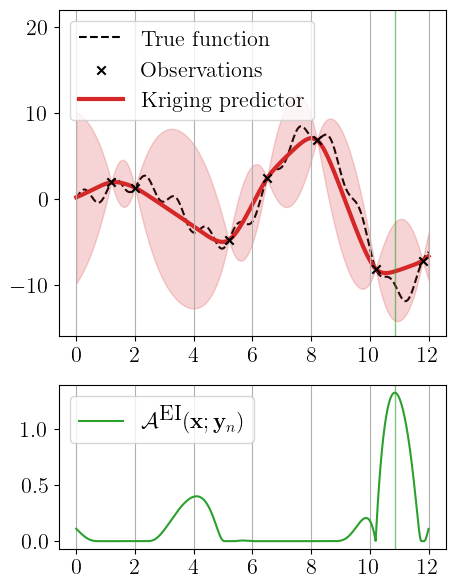

In [9]:
fig, axs = plt.subplots(2, figsize=(5, 7), height_ratios=[2, 1])
plot_kriging(axs[0], kriging_results)
axs[1].plot(x_node, EI_0, label="$\mathcal{A}^{\\textrm{EI}}(\\mathbf{x}; \\mathbf{y}_n)$", color="C2")
axs[1].legend(loc='upper left')
axs[1].set_xticks([0, 2, 4, 6, 8, 10, 12])
#axs[1].set_ylim(-0.05, 1.5)
axs[0].axvline(x_star_0, color="C2", alpha=0.6, linewidth=1)
axs[1].axvline(x_star_0, color="C2", alpha=0.6, linewidth=1)
axs[1].xaxis.grid()
plt.savefig("figures/bayesian_opt_0.png", dpi=300, bbox_inches='tight');

In [10]:
x_train = np.vstack((x_train, np.array([x_star_0])))
y_train.add(g([x_star_0]))
algo = ot.KrigingAlgorithm(x_train, y_train, covarianceModel, basis)
algo.run()
kriging_results = algo.getResult()
current_ymin = np.min(y_train)
EI_1 = EI(kriging_results, current_ymin)
x_star_1 = x_node[np.argmax(EI_1)]

/tmp/ipykernel_13787/1625502500.py:6: RuntimeWarning: divide by zero encountered in divide
  tmp = (current_ymin - y_predictor) / y_std


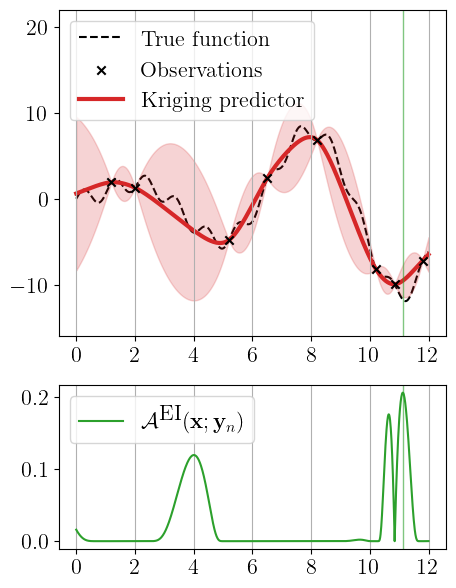

In [11]:
fig, axs = plt.subplots(2, figsize=(5, 7), height_ratios=[2, 1])
plot_kriging(axs[0], kriging_results)
axs[1].plot(x_node, EI_1, label="$\mathcal{A}^{\\textrm{EI}}(\\mathbf{x}; \\mathbf{y}_n)$", color="C2")
axs[1].legend(loc='upper left')
axs[1].set_xticks([0, 2, 4, 6, 8, 10, 12])
#axs[1].set_ylim(-0.05, 1.5)
axs[0].axvline(x_star_1, color="C2", alpha=0.6, linewidth=1)
axs[1].axvline(x_star_1, color="C2", alpha=0.6, linewidth=1)
axs[1].xaxis.grid()
plt.savefig("figures/bayesian_opt_1.png", dpi=300, bbox_inches='tight');

In [12]:
x_train = np.vstack((x_train, np.array([x_star_1])))
y_train.add(g([x_star_1]))
algo = ot.KrigingAlgorithm(x_train, y_train, covarianceModel, basis)
algo.run()
kriging_results = algo.getResult()
current_ymin = np.min(y_train)
EI_2 = EI(kriging_results, current_ymin)
x_star_2 = x_node[np.argmax(EI_2)]

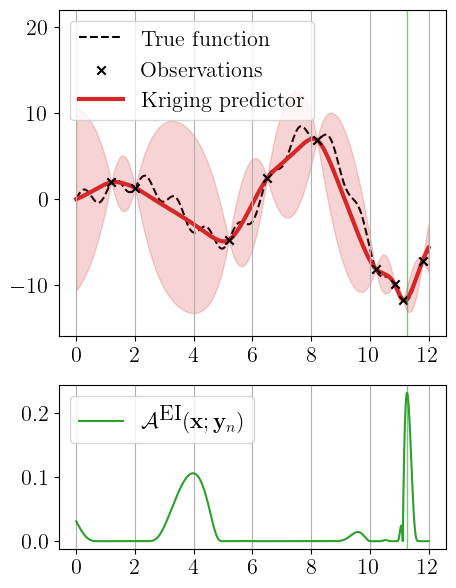

In [13]:
fig, axs = plt.subplots(2, figsize=(5, 7), height_ratios=[2, 1])
plot_kriging(axs[0], kriging_results)
axs[1].plot(x_node, EI_2, label="$\mathcal{A}^{\\textrm{EI}}(\\mathbf{x}; \\mathbf{y}_n)$", color="C2")
axs[1].legend(loc='upper left')
axs[1].set_xticks([0, 2, 4, 6, 8, 10, 12])
#axs[1].set_ylim(-0.05, 1.5)
axs[0].axvline(x_star_2, color="C2", alpha=0.6, linewidth=1)
axs[1].axvline(x_star_2, color="C2", alpha=0.6, linewidth=1)
axs[1].xaxis.grid()
plt.savefig("figures/bayesian_opt_2.png", dpi=300, bbox_inches='tight');

## Active contour finding

In [14]:
x_node = np.linspace(0., 12., 5000)
y_true = np.array(g(x_node.reshape(-1, 1))).flatten()

In [15]:
yth = -8.
g = ot.SymbolicFunction(['x'], ['x * sin(x) + sin(6 * x)'])
x_train = np.array([1.2, 2., 5.2, 6.5, 8.2, 10.2,11.8]).reshape(-1, 1)
#x_train = np.array([1., 2., 3.5, 5.5, 7., 8.5, 10.5]).reshape(-1, 1)
y_train = g(x_train)
n = len(y_train)

basis = ot.ConstantBasisFactory(1).build()
covarianceModel = ot.MaternModel([1.], 1.5)
algo = ot.KrigingAlgorithm(x_train, y_train, covarianceModel, basis)
algo.run()
kriging_results = algo.getResult()
predictor = kriging_results.getMetaModel()

In [16]:
def U(kriging_results):
    y_predictor = kriging_results.getConditionalMean(x_node.reshape(-1, 1))
    y_predictor = np.array(y_predictor).flatten()
    y_variance = kriging_results.getConditionalMarginalVariance(x_node.reshape(-1, 1))
    y_variance = np.array(y_variance).flatten()
    U = np.divide(np.abs(yth - y_predictor), y_variance)
    return U

In [17]:
U_0 = U(kriging_results)
x_star_0 = x_node[np.argmin(U_0)]

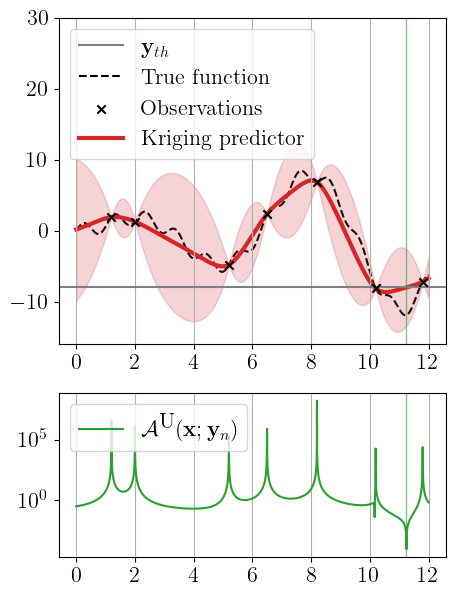

In [18]:
fig, axs = plt.subplots(2, figsize=(5, 7), height_ratios=[2, 1])
axs[0].axhline(yth, label="$\mathbf{y}_{th}$", color='C7')
plot_kriging(axs[0], kriging_results, ylim=30)
axs[1].plot(x_node, U_0, label="$\mathcal{A}^{\\textrm{U}}(\\mathbf{x}; \\mathbf{y}_n)$", color="C2")
axs[1].legend(loc='upper left')
axs[1].set_xticks([0, 2, 4, 6, 8, 10, 12])
#axs[1].set_ylim(-0.05, 1.5)
axs[0].axvline(x_star_0, color="C2", alpha=0.6, linewidth=1)
axs[1].axvline(x_star_0, color="C2", alpha=0.6, linewidth=1)
axs[1].xaxis.grid()
axs[1].set_yscale('log')
plt.savefig("figures/contour_find_0.png", dpi=300, bbox_inches='tight');

In [19]:
x_train = np.vstack((x_train, np.array([x_star_0])))
y_train.add(g([x_star_0]))
algo = ot.KrigingAlgorithm(x_train, y_train, covarianceModel, basis)
algo.run()
kriging_results = algo.getResult()
U_1 = U(kriging_results)
x_star_1 = x_node[np.argmin(U_1)]

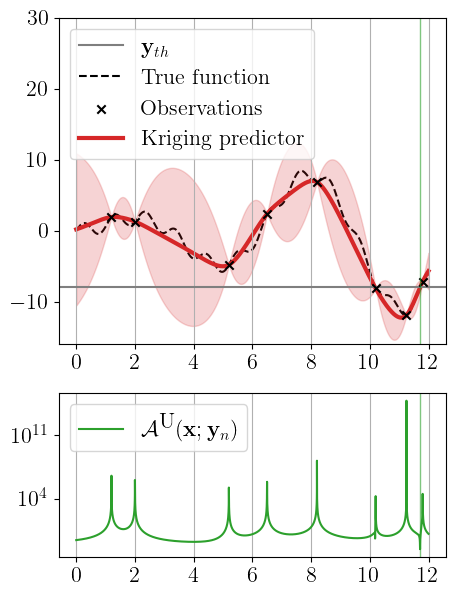

In [20]:
fig, axs = plt.subplots(2, figsize=(5, 7), height_ratios=[2, 1])
axs[0].axhline(yth, label="$\mathbf{y}_{th}$", color='C7')
plot_kriging(axs[0], kriging_results, ylim=30)
axs[1].plot(x_node, U_1, label="$\mathcal{A}^{\\textrm{U}}(\\mathbf{x}; \\mathbf{y}_n)$", color="C2")
axs[1].legend(loc='upper left')
axs[1].set_xticks([0, 2, 4, 6, 8, 10, 12])
#axs[1].set_ylim(-0.05, 1.5)
axs[0].axvline(x_star_1, color="C2", alpha=0.6, linewidth=1)
axs[1].axvline(x_star_1, color="C2", alpha=0.6, linewidth=1)
axs[1].xaxis.grid()
axs[1].set_yscale('log')
plt.savefig("figures/contour_find_1.png", dpi=300, bbox_inches='tight');

In [21]:
x_train = np.vstack((x_train, np.array([x_star_1])))
y_train.add(g([x_star_1]))
algo = ot.KrigingAlgorithm(x_train, y_train, covarianceModel, basis)
algo.run()
kriging_results = algo.getResult()
U_2 = U(kriging_results)
x_star_2 = x_node[np.argmin(U_2)]

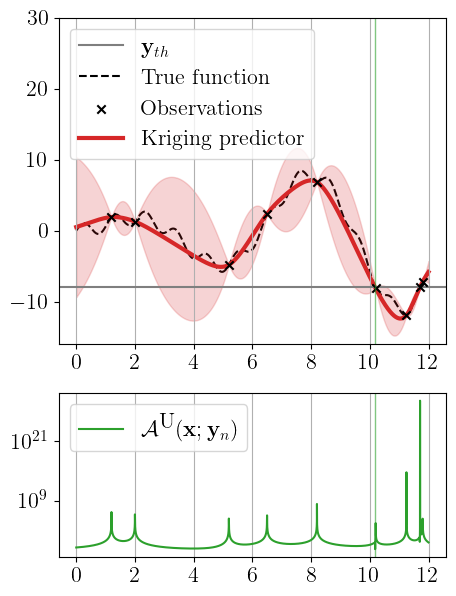

In [22]:
fig, axs = plt.subplots(2, figsize=(5, 7), height_ratios=[2, 1])
axs[0].axhline(yth, label="$\mathbf{y}_{th}$", color='C7')
plot_kriging(axs[0], kriging_results, ylim=30)
axs[1].plot(x_node, U_2, label="$\mathcal{A}^{\\textrm{U}}(\\mathbf{x}; \\mathbf{y}_n)$", color="C2")
axs[1].legend(loc='upper left')
axs[1].set_xticks([0, 2, 4, 6, 8, 10, 12])
#axs[1].set_ylim(-0.05, 1.5)
axs[0].axvline(x_star_2, color="C2", alpha=0.6, linewidth=1)
axs[1].axvline(x_star_2, color="C2", alpha=0.6, linewidth=1)
axs[1].xaxis.grid()
axs[1].set_yscale('log')
plt.savefig("figures/contour_find_2.png", dpi=300, bbox_inches='tight');